# Resample and Stratify Data 
The original [Yelp review data](https://www.kaggle.com/yelp-dataset/yelp-dataset#yelp_academic_dataset_review.json) contains more than 5 million reviews, which is far too large to train our Flair model on, so we subset this data to a few tens of thousands of reviews. 

However, we run into the issue that there is a class imbalance if we simply randomly sample the review data. 

In [1]:
import json
import csv
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('mode.chained_assignment', None)

### Reduce the original dataset

The below section assumes that the Yelp data ```review.json``` with the 5.8 million reviews is present in the current directory. The resampled data is output to another file. 

In [3]:
limit = 200000   # Line limit to stop reading training input file

In [4]:
def reduce_yelp(reviews_data, reduced_path):
    with open(reviews_data) as input, \
        open(reduced_path, "w") as output:

        c = 0
        for line in input:
            c += 1
            review_data = json.loads(line)
            rating = int(float(review_data['stars']))
            text = review_data['text'].replace("\n", " ")

            flair_line = "{}\t{}".format(rating, text)
            output.write(flair_line + "\n")
            if c == limit:
                break
                
reduce_yelp("review.json", "yelp_reduced.tsv")

In [5]:
df = pd.read_csv('yelp_reduced.tsv', sep='\t', 
                   index_col=None, header=None, 
                   names=['score', 'review'],
                   lineterminator='\n')
df.head()

,score,review
0,1,Total bill for this horrible service? Over $8G...
1,5,I *adore* Travis at the Hard Rock's new Kelly ...
2,5,I have to say that this office really has it t...
3,5,Went in for a lunch. Steak sandwich was delici...
4,1,Today was my second out of three sessions I ha...


5    88444
4    44059
1    29316
3    22088
2    16078
Name: score, dtype: int64


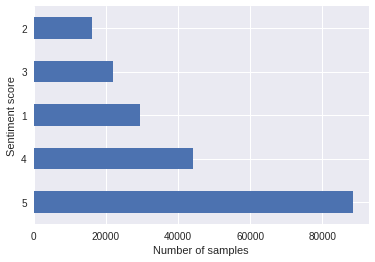

In [6]:
counts = df['score'].value_counts()
counts.plot(kind='barh');
plt.xlabel('Number of samples');
plt.ylabel('Sentiment score');
print(counts)

We can clearly see that not all classes have the same number of samples. We look at the minimum of these and then undersample the rest of the data. 

In [7]:
# Get individual counts
c5, c4, c1, c3, c2 = df['score'].value_counts()

minority = min(c1, c2, c3, c4, c5)

# Divide by class
df_1 = df[df['score'] == 1]
df_2 = df[df['score'] == 2]
df_3 = df[df['score'] == 3]
df_4 = df[df['score'] == 4]
df_5 = df[df['score'] == 5]

### Undersample data
To produce reproducible samples, we set a random seed and then obtain a stratified set of samples with a number equal to the minority class.

In [8]:
# Set random seed for sampling and stratification
seed = 37 

In [9]:
df_1_under = df_1.sample(minority, random_state=seed)
df_2_under = df_2.sample(minority, random_state=seed)
df_3_under = df_3.sample(minority, random_state=seed)
df_4_under = df_4.sample(minority, random_state=seed)
df_5_under = df_5.sample(minority, random_state=seed)

In [10]:
df_under = pd.concat((df_1_under, df_2_under, df_3_under, df_4_under, df_5_under), axis=0)
df_under.shape

(80390, 2)

5    16078
4    16078
3    16078
2    16078
1    16078
Name: score, dtype: int64


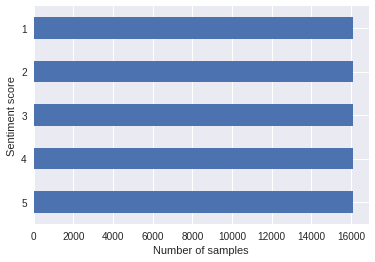

In [11]:
undersampled_counts = df_under['score'].value_counts()
undersampled_counts.plot(kind='barh');
plt.xlabel('Number of samples');
plt.ylabel('Sentiment score');
print(undersampled_counts)

All the 5 classes now have the same number of samples, which makes this suitable for training our classifier.

### Export stratified data for analysis
Based on the compute and memory requirements for the Flair model, we vary the ```train_size``` parameter to get a training sample that trains in reasonable time without causing the GPU to run out of memory.

In [12]:
train, test = train_test_split(df_under,
                               train_size=0.5,
                               test_size=0.1,
                               random_state=seed,
                               stratify=df_under['score']
                              )

In [13]:
print("Training set: {} samples".format(train.shape[0]))
print("Test set: {} samples".format(test.shape[0]))
print("Each class in the training set has {} samples".format(train[train.score == 1].shape[0]))

Training set: 40195 samples
Test set: 8039 samples
Each class in the training set has 8039 samples


### Export train and test data 

In [14]:
train['score_fasttext'] = '__label__' + train['score'].astype(str)
test['score_fasttext'] = '__label__' + test['score'].astype(str)
train_final = train[['score_fasttext', 'review']]
test_final = test[['score_fasttext', 'review']]
train_final.to_csv('train.csv', sep='\t', index=None, header=None)
test_final.to_csv('test.csv', sep='\t', index=None, header=None)